# Altering table definitions in place (new in release 0.12.0)

This and other notebooks for this video series are found at

https://github.com/vathes/db-programming-with-datajoint

This notebook describes how to alter table definitions in place without losing the data they already contain.

First, let's connection to an existing database:

In [1]:
import datajoint as dj
schema = dj.schema('university')
schema.spawn_missing_classes()

Connecting dimitri@localhost:3306


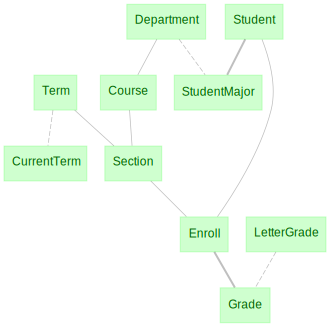

In [2]:
dj.Diagram(schema)

Let's define table `Exam` to contain the results of midterm and final exams.

In [3]:
@schema
class Exam(dj.Manual):
    definition = """
    -> Enroll 
    ---
    score  : decimal(5,2)   # percent of total 
    """

Let's change the definition to record the exam date too

In [4]:
@schema
class Exam(dj.Manual):
    definition = """
    -> Enroll
    ---
    exam_date : date
    score  : decimal(5,2)   # percent of total 
    """

Even though we updated the `definition` in the class, the change is not reflected on the server:

In [5]:
Exam()

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section,score percent of total


You can examine the definition on the server using the `describe` method:

In [6]:
Exam.describe();

-> Enroll
---
score                : decimal(5,2)                 # percent of total



In [7]:
print(Exam.definition)


    -> Enroll
    ---
    exam_date : date
    score  : decimal(5,2)   # percent of total 
    


One solution is to simply drop the table and declare it again, which is fine when it contains no valuable data. But let's consider the case when the table is already populated and we wish to keep the existing data.  

First, let's insert some exam entries:

In [8]:
# pick 100 random enrollments from the current term
import random
keys = random.sample(((Enroll - Exam) & CurrentTerm).fetch('KEY'), 100)
# assign random scores
for key in keys:
    Exam.insert1(dict(key, score=random.randint(0,10000)/100))

Now we can alter the `Exam` table with the new definition:

In [9]:
Exam()

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section,score percent of total
1069,PHYS,2100,2018,Fall,a,79.15
1084,MATH,1250,2018,Fall,a,44.69
1164,BIOL,1006,2018,Fall,b,78.62


We can now use the `alter` method to apply the new definition:

In [10]:
Exam.alter()

ALTER TABLE `university`.`exam`
	ADD `exam_date` date NOT NULL AFTER `section`,
	MODIFY `score` decimal(5,2) NOT NULL COMMENT "percent of total" AFTER `exam_date`

Execute? [yes, no]: yes


InternalError: (1292, "Incorrect date value: '0000-00-00' for column 'exam_date' at row 1")

Oh! New attributes cannot be added to tables with existing data without providing a default value. Let's update the definition to allow `exam_date` to be empty (default to `null`) and alter the table again.

In [11]:
@schema
class Exam(dj.Manual):
    definition = """
    -> Enroll 
    ---
    exam_date = null: date  
    score  : decimal(5,2)   # percent of total 
    """

In [12]:
Exam.alter()

ALTER TABLE `university`.`exam`
	ADD `exam_date` date DEFAULT NULL AFTER `section`,
	MODIFY `score` decimal(5,2) NOT NULL COMMENT "percent of total" AFTER `exam_date`

Execute? [yes, no]: yes
Table altered


In [13]:
Exam()

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section,exam_date,score percent of total
1069,PHYS,2100,2018,Fall,a,None,79.15
1084,MATH,1250,2018,Fall,a,None,44.69
1164,BIOL,1006,2018,Fall,b,None,78.62


Now let's add some grades for today's exam:

In [14]:
from datetime import datetime
today = datetime.now().date().isoformat()

In [15]:
# pick 20 random enrollments from the current term
keys = random.sample(((Enroll - Exam) & CurrentTerm).fetch('KEY'), 20)
# assign random scores
for key in keys:
    Exam.insert1(dict(key, score=random.randint(0,10000)/100, exam_date=today))

In [16]:
Exam()

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section,exam_date,score percent of total
1069,PHYS,2100,2018,Fall,a,None,79.15
1084,MATH,1250,2018,Fall,a,None,44.69
1088,CS,3100,2018,Fall,a,2019-04-23,17.70


Now let's say we want to rename `score` into `exam_score`:

In [17]:
@schema
class Exam(dj.Manual):
    definition = """
    -> Enroll 
    ---
    exam_date = null: date  
    exam_score  : decimal(5,2)   # percent of total 
    """

In [18]:
# Say NO!
Exam.alter()

ALTER TABLE `university`.`exam`
	DROP `score`,
	ADD `exam_score` decimal(5,2) NOT NULL COMMENT "percent of total" AFTER `exam_date`

Execute? [yes, no]: no


Note that rather than renaming, `alter` attempted to drop the old attribute and add the new one. 

To rename, we must indicate the old attribute name in curly brackets as the first thing in the attribute comment:

In [19]:
@schema
class Exam(dj.Manual):
    definition = """
    -> Enroll 
    ---
    exam_date = null: date  
    exam_score  : decimal(5,2)   # {score} percent of total 
    """

In [20]:
Exam.alter()

ALTER TABLE `university`.`exam`
	CHANGE `score` `exam_score` decimal(5,2) NOT NULL COMMENT "{score} percent of total" 

Execute? [yes, no]: yes
Table altered


In [21]:
Exam()

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section,exam_date,exam_score {score} percent of total
1069,PHYS,2100,2018,Fall,a,None,79.15
1084,MATH,1250,2018,Fall,a,None,44.69
1088,CS,3100,2018,Fall,a,2019-04-23,17.70


The old attribute name is preserved in the comment just in case, but you can remove it with another `alter` command:

In [22]:
Exam.describe();

-> Enroll
---
exam_date=null       : date                         
exam_score           : decimal(5,2)                 # {score} percent of total



In [23]:
@schema
class Exam(dj.Manual):
    definition = """
    -> Enroll 
    ---
    exam_date = null: date  
    exam_score  : decimal(5,2)   # percent of total 
    """

In [24]:
Exam.alter()

ALTER TABLE `university`.`exam`
	MODIFY `exam_score` decimal(5,2) NOT NULL COMMENT "percent of total" 

Execute? [yes, no]: yes
Table altered


In [25]:
Exam.describe();

-> Enroll
---
exam_date=null       : date                         
exam_score           : decimal(5,2)                 # percent of total



We can change the data type of an existing attribute as long as the existing data can fit. However, some precision may be lost.

For example, let's attempt to change the `exam_score` attribute into a `tinyint unsigned`. This will result in the rounding of the scores:

In [26]:
@schema
class Exam(dj.Manual):
    definition = """
    -> Enroll 
    ---
    exam_date = null: date  
    exam_score  : tinyint unsigned  # percent of total 
    """

In [27]:
Exam.alter()

ALTER TABLE `university`.`exam`
	MODIFY `exam_score` tinyint unsigned NOT NULL COMMENT "percent of total" 

Execute? [yes, no]: yes
Table altered


In [28]:
Exam()

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section,exam_date,exam_score percent of total
1069,PHYS,2100,2018,Fall,a,None,79
1084,MATH,1250,2018,Fall,a,None,45
1088,CS,3100,2018,Fall,a,2019-04-23,18


But if we attmept to change it to `decimal(3,2)`, for example, we may get an error because some values are too large to fit in this data type.

In [29]:
@schema
class Exam(dj.Manual):
    definition = """
    -> Enroll 
    ---
    exam_date = null: date  
    exam_score  : decimal(3,2)   # percent of total 
    """

In [30]:
Exam.alter()

ALTER TABLE `university`.`exam`
	MODIFY `exam_score` decimal(3,2) NOT NULL COMMENT "percent of total" 

Execute? [yes, no]: yes


DataError: (1264, "Out of range value for column 'exam_score' at row 1")

In [31]:
@schema
class Exam(dj.Manual):
    definition = """
    -> Enroll 
    ---
    exam_date = null: date  
    exam_score  : decimal(5,2)   # percent of total 
    """

In [32]:
Exam.alter()

ALTER TABLE `university`.`exam`
	MODIFY `exam_score` decimal(5,2) NOT NULL COMMENT "percent of total" 

Execute? [yes, no]: yes
Table altered


In [33]:
# restored to higher precision but fractional part has been lost:
Exam()

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section,exam_date,exam_score percent of total
1069,PHYS,2100,2018,Fall,a,None,79.00
1084,MATH,1250,2018,Fall,a,None,45.00
1088,CS,3100,2018,Fall,a,2019-04-23,18.00


Finally, let's add a table comment and reorder the attributes:

In [34]:
@schema
class Exam(dj.Manual):
    definition = """
    # Exam taken by a student enrolled in a course section and the grade
    -> Enroll 
    ---
    exam_score  : decimal(5,2)   # percent of total 
    exam_date = null: date  
    """

In [35]:
Exam.alter()

ALTER TABLE `university`.`exam`
	MODIFY `exam_score` decimal(5,2) NOT NULL COMMENT "percent of total" AFTER `section`,
	MODIFY `exam_date` date DEFAULT NULL AFTER `exam_score`,
	COMMENT="Exam taken by a student enrolled in a course section and the grade"

Execute? [yes, no]: yes
Table altered


In [36]:
Exam()

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section,exam_score percent of total,exam_date
1069,PHYS,2100,2018,Fall,a,79.00,None
1084,MATH,1250,2018,Fall,a,45.00,None
1088,CS,3100,2018,Fall,a,18.00,2019-04-23


In [37]:
#clean up
Exam.drop()

`university`.`exam` (120 tuples)
Proceed? [yes, No]: yes
Tables dropped.  Restart kernel.
